In [2]:
import torch
print(torch.__version__)

2.5.1


In [3]:
torch.manual_seed(42)

In [7]:
x = torch.Tensor([1, 2, 3])
print(x)
print(type(x))

y = torch.rand(3)
print(y)

tensor([1., 2., 3.])
<class 'torch.Tensor'>
tensor([0.9593, 0.3904, 0.6009])


In [8]:
tensor = torch.arange(4)
x1 = torch.rand(2, 3)
x2 = torch.rand(2, 3)

print(x1)
print(x2)
y = x1 - x2
print(y)

tensor([[0.2566, 0.7936, 0.9408],
        [0.1332, 0.9346, 0.5936]])
tensor([[0.8694, 0.5677, 0.7411],
        [0.4294, 0.8854, 0.5739]])
tensor([[-0.6128,  0.2259,  0.1997],
        [-0.2962,  0.0492,  0.0197]])


In [41]:
sd = torch.arange(5, 10, 1)
sd1 = torch.rand(2, 6, 4)
print(sd)
print(sd1.view(1,1, len(sd1.flatten())))

tensor([5, 6, 7, 8, 9])
tensor([[[0.3211, 0.7177, 0.3393, 0.4916, 0.0648, 0.3693, 0.2371, 0.3313,
          0.1807, 0.0503, 0.5326, 0.8245, 0.9554, 0.7918, 0.2408, 0.0055,
          0.6897, 0.7802, 0.0707, 0.6793, 0.9227, 0.5303, 0.1988, 0.9099,
          0.7135, 0.8311, 0.1619, 0.7910, 0.1585, 0.9947, 0.2882, 0.8013,
          0.6001, 0.6325, 0.4233, 0.7054, 0.2916, 0.0287, 0.3079, 0.8918,
          0.3684, 0.6572, 0.3151, 0.8751, 0.7992, 0.6765, 0.2444, 0.0914]]])


In [46]:
x = torch.ones(3)

print(x.requires_grad)
x.requires_grad_(True)
print(x.requires_grad)


False
True


In [47]:
x = torch.arange(3, dtype=torch.float32, requires_grad=True)
print("X: ", x)

X:  tensor([0., 1., 2.], requires_grad=True)


In [48]:
a = x + 2
b = a ** 2
c = b + 1
y = c.mean()
print("Y: ", y)

print(x)

Y:  tensor(10.6667, grad_fn=<MeanBackward0>)
tensor([0., 1., 2.], requires_grad=True)


In [49]:
y.backward()
print(x.grad)

tensor([1.3333, 2.0000, 2.6667])


In [ ]:
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

False
tensor([1.], device='mps:0')


In [52]:
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
print("Device", device)

Device mps


In [54]:
x = torch.zeros(2, 3)
x = x.to(device)
print("X", x)

X tensor([[0., 0., 0.],
        [0., 0., 0.]], device='mps:0')


In [57]:
import time
x = torch.randn(10000, 10000)

start_time = time.time()
_ = torch.matmul(x, x)
end_time = time.time()

print(f"CPU Time: {end_time - start_time}")

x = x.to(device)
_ = torch.matmul(x, x)

start_time = time.time()
_ = torch.matmul(x, x)
torch.mps.synchronize()
end_time = time.time()

print(f"MPS Time: {end_time - start_time}")


CPU Time: 2.624166965484619
MPS Time: 5.9662699699401855


In [ ]:
torch.manual_seed(1234)
TENSOR_A_CPU = torch.rand(100000, 100000)
TENSOR_B_CPU = torch.rand(100000, 100000)

torch.manual_seed(1234)
TENSOR_A_MPS = torch.rand(100000, 100000).to(device)
TENSOR_B_MPS = torch.rand(100000, 100000).to(device)

# Warm-up
for _ in range(100):
    torch.matmul(torch.rand(500,500).to(device), torch.rand(500,500).to(device))
    
start_time = time.time()
torch.matmul(TENSOR_A_CPU, TENSOR_B_CPU)
print("CPU : --- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
torch.matmul(TENSOR_A_MPS, TENSOR_B_MPS)
print("MPS : --- %s seconds ---" % (time.time() - start_time))

CPU : --- 3.605742931365967 seconds ---
MPS : --- 0.0023162364959716797 seconds ---


In [1]:
import torch.nn as nn

import torch.nn.functional as F

In [10]:
class SimpleClassifier(nn.Module):
    def __init__(self, num_inputs, num_hidden, num_outputs):
        super().__init__()

        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.act_fn = nn.Tanh()
        self.linear2 = nn.Linear(num_hidden, num_outputs)

    def forward(self, x):
        x = self.linear1(x)
        x = self.act_fn(x)
        x = self.linear2(x)
        return x

In [11]:
model = SimpleClassifier(num_inputs=3, num_hidden=4, num_outputs=1)
print(model)

SimpleClassifier(
  (linear1): Linear(in_features=3, out_features=4, bias=True)
  (act_fn): Tanh()
  (linear2): Linear(in_features=4, out_features=1, bias=True)
)


In [12]:
for name, param in model.named_parameters():
    print(name, param.shape)

linear1.weight torch.Size([4, 3])
linear1.bias torch.Size([4])
linear2.weight torch.Size([1, 4])
linear2.bias torch.Size([1])


In [28]:
import torch.utils.data as data

class XORDataset(data.Dataset):
    def __init__(self, size, std=0.1):
        super().__init__()
        self.size = size
        self.std = std
        self.generate_continuous_xor()

    def generate_continuous_xor(self):
        data = torch.randint(low=0, high=2, size=(self.size, 2), dtype=torch.float32)
        label = (data.sum(dim=1) == 1).to(torch.long)
        data += self.std * torch.randn(data.shape)

        self.data = data
        self.label = label

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        data_point = self.data[idx]
        data_label = self.label[idx]
        return data_point, data_label

In [29]:
dataset = XORDataset(size=200)
print("Size of dataset: ", len(dataset))
print("Data point 0: ", dataset[0])

Size of dataset:  200
Data point 0:  (tensor([0.1009, 0.8979]), tensor(1))


In [31]:
import matplotlib.pyplot as plt
def visualize_samples(data, label):
    if isinstance(data, torch.Tensor):
        data = data.cpu().numpy()
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    data_0 = data[label == 0]
    data_1 = data[label == 1]

    plt.figure(figsize=(4,4))
    plt.scatter(data_0[:,0], data_0[:,1], edgecolor="#333", label="Class 0")
    plt.scatter(data_1[:,0], data_1[:,1], edgecolor="#333", label="Class 1")
    plt.title("Dataset samples")
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.legend()

Matplotlib is building the font cache; this may take a moment.


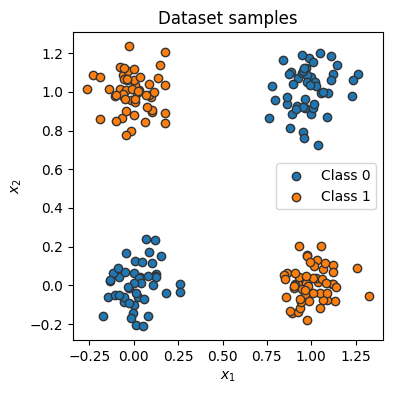

In [32]:
visualize_samples(dataset.data, dataset.label)
plt.show()

In [35]:
data_loader = data.DataLoader(dataset, batch_size=8, shuffle=True)

In [37]:
data_inputs , data_labels = next(iter(data_loader))

print("Data inputs: ", data_inputs.shape, "\n ", data_inputs)
print("Data labels: ", data_labels.shape, "\n ", data_labels)

Data inputs:  torch.Size([8, 2]) 
  tensor([[ 0.0329,  1.0774],
        [ 0.9177,  0.9294],
        [ 0.9782,  1.0491],
        [-0.1163,  0.0649],
        [ 0.9682,  0.0107],
        [ 0.9556,  0.7944],
        [ 0.7806,  1.0289],
        [ 1.0790,  0.1136]])
Data labels:  torch.Size([8]) 
  tensor([1, 0, 0, 0, 1, 0, 0, 1])


In [38]:
loss_module = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)